In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import ast
import sys
sys.path.append('/home/group3/group3/Finalized')
from Backtester import *

In [3]:
company = pd.read_parquet('/home/group3/group3/Finalized/data/company_overview_cleaned.parquet')
# glassd_classification = pd.read_parquet('/home/group3/group3/Finalized/data/glassd_classification_cleaned.parquet')
# text = pd.read_parquet('/home/group3/glassdoor/glassd_review_internal_data_2024-03-19.parquet')
# stock_monthly = pd.read_csv('/home/group3/group3/Finalized/data/stock_monthly.csv')
# stock_monthly['date'] = pd.to_datetime(stock_monthly['date'])
# rolling_ret = pd.read_csv('/home/group3/group3/Finalized/data/rolling_future_ret.csv')
# rolling_ret['date'] = pd.to_datetime(rolling_ret['date'])
# rolling_ratings = pd.read_csv('/home/group3/group3/Finalized/data/rolling_period_ratings_stats.csv')
# rolling_ratings['reviewDateTime'] = pd.to_datetime(rolling_ratings['reviewDateTime'])
# rolling_ret_rating = pd.merge(rolling_ratings,rolling_ret, left_on=['ticker','reviewDateTime'], right_on=['ticker','date'])

In [4]:
filters = pd.read_pickle('/home/group3/group3/Finalized/groupings/filters.pkl')
by_employee = pd.read_csv('/home/group3/group3/Finalized/groupings/by_employee.csv')
by_industry = pd.read_csv('/home/group3/group3/Finalized/groupings/by_industry.csv')
by_revenue = pd.read_csv('/home/group3/group3/Finalized/groupings/by_revenue.csv')

In [5]:
features_db = pd.read_pickle('/home/group3/group3/Finalized/data/DB@rating_numeric_12.pkl')

In [6]:
features_db.head()

ratingOverall_count                                            ...  \
ticker                       A  AA AAL AAME AAOI AAON AAP AAPL AAWW ABBV  ...   
date                                                                      ...   
2008-04-30                 NaN NaN NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  ...   
2008-05-31                 NaN NaN NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  ...   
2008-06-30                 NaN NaN NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  ...   
2008-07-31                 NaN NaN NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  ...   
2008-08-31                 NaN NaN NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  ...   

           ratingDiversityAndInclusion_mean                                \
ticker                                 ZDGE ZEUS ZION ZIP  ZM ZOM  ZS ZTS   
date                                                                        
2008-04-30                              NaN  NaN  NaN NaN NaN NaN NaN NaN   
2008-05-31                              NaN  NaN  NaN NaN NaN NaN NaN NaN   
2008-06-30                              NaN  NaN  NaN NaN NaN NaN NaN NaN   
2008-07-31                              NaN  NaN  NaN NaN NaN NaN NaN NaN   
2008-08-31                              NaN  NaN  NaN NaN NaN NaN NaN NaN   

                      
ticker     ZUMZ ZYXI  
date                  
2008-04-30  NaN  NaN  
2008-05-31  NaN  NaN  
2008-06-30  NaN  NaN  
2008-07-31  NaN  NaN  
2008-08-31  NaN  NaN  

[5 rows x 35294 columns]

In [7]:
import os
import pandas as pd
import json

def csv_to_json(directory, output_json_file):
    # Dictionary to hold DataFrames
    dataframes_dict = {}

    # Iterate through all files in the specified directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.csv'):
            # Create full path to the file
            file_path = os.path.join(directory, file_name)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Use the file name (without .csv) as the key
            key = os.path.splitext(file_name)[0]
            dataframes_dict[key] = df

    # Convert the dictionary of DataFrames to a dictionary of records
    records_dict = {key: df.to_dict(orient='records') for key, df in dataframes_dict.items()}

    # Save the dictionary to a JSON file
    with open(output_json_file, 'w') as json_file:
        json.dump(records_dict, json_file, indent=4)

    print(f'Dictionary saved to {output_json_file}')

# directory_path = '/home/group3/group3/Drafts/Jadon/BT_res' 
# output_json_path = 'experiments.json'
# csv_to_json(directory_path, output_json_path)

def read_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data


def update_json(file_path, exp_name, exp_data):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    data[exp_name] = exp_data.to_dict(orient='records')

    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

json_file_path = 'experiments.json' 
data = read_json(json_file_path)

In [8]:
class BackTest:
    """
    Backtester for backtesting alpha ideas

    - returns are preprocessed: columns being ticker, row being EOM date (2020-01-31) means return from 2020-02-01 - 2020-02-28

    """
    def __init__(self, features, grouping=None, start_date='2019-01-01', end_date='2022-12-30', universe=None, market_neutral=True, decay=3):
        self.ret = pd.read_csv('/home/group3/group3/Finalized/data/universe_ret.csv',index_col=0)
        self.ret = self.ret.loc[start_date:end_date,:]

        self.features = features
        self.market_neutral=market_neutral
        self.start_date = start_date
        self.end_date = end_date
        self.decay=decay


        # result dataframes
        self.weights = None
        self.portfolio_returns = pd.DataFrame()
        self.metrics = pd.DataFrame()


        # grouping
        if isinstance(grouping, pd.DataFrame):
            # filter stocks first (universe check)
            universe = self.ret.columns.unique().values
            self.ret = self.ret.loc[:,universe]
            
            self.features = self.features.loc[:, self.features.columns.get_level_values('ticker').isin(universe)]

            # 1. group ret (assume equal weight portfolio)
            ret_merge = pd.merge(self.ret.T, grouping, left_on=self.ret.T.index, right_on='ticker')
            ret_merge.set_index('ticker',inplace=True)
            self.ret = ret_merge.groupby('group').mean().T

            # 2. group features (take mean)
            columns = self.features.columns.get_level_values(0).unique()
            df = pd.DataFrame()
            new_columns = []
            for feature in columns:
                merge = pd.merge(self.features[feature].T, grouping, left_on=self.features[feature].T.index, right_on='ticker')
                merge.set_index('ticker',inplace=True)
                merge = merge.groupby('group').mean().T
                df = pd.concat([df, merge],axis=1)
                new_columns += [(feature,col) for col in merge.columns]

            new_columns = pd.MultiIndex.from_tuples(new_columns)
            df.columns = new_columns
            self.features = df
            self.features.columns = self.features.columns.set_names(['feature', 'ticker'])


        # define universe, we do not need this if grouping is defined
        if not isinstance(grouping, pd.DataFrame):
            if universe is not None:
                universe = list(set(universe) & set(self.ret.columns.unique()))
                self.ret = self.ret.loc[:,universe]
        universe = self.ret.columns.unique().values
        self.features = self.features.loc[:, self.features.columns.get_level_values('ticker').isin(universe)]


    def create_alpha(self, weight):
        weight = weight.loc[self.start_date:self.end_date,:]
        self.weights = weight
    
    def run(self, display_plot=True):
        assert self.weights is not None, "Please assign weights before running with self.weight = {your defined weights}"
        self.weights = self.weights[self.ret.columns]
        if self.market_neutral:
            self.weights = self.make_market_neutral(self.weights)

        if self.decay>0:
            self.weights = self.weight_decay(self.weights,window=self.decay)


        self.portfolio_returns = self.weights.mul(self.ret).sum(axis=1)
        self.metrics = self.get_metrics()
        if display_plot:
            self.plot_pnl()
            display(self.metrics)
        return self.metrics


    # portfolio transformation functions

    def make_market_neutral(self, weights):
        # make weight of portfolio sum to 0, absolute value sum to 1
        abs_sum = weights.abs().sum(axis=1)
        weights = weights.sub(weights.mean(axis=1), axis=0).div(abs_sum,axis=0)
        return weights

    def weight_decay(self, weight, window=6):
        weight = weight.rolling(window=window,min_periods=1).mean()
        return weight


    def plot_pnl(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.portfolio_returns.index, (1+self.portfolio_returns).cumprod(), label='PnL')
        plt.xlabel('date')
        plt.ylabel('return')
        plt.title('PnL')
        plt.legend()
        # unique_years = pd.to_datetime(self.portfolio_returns.index).year
        # labels = [(f"{year}-01-31") for year in unique_years]
        plt.xticks(range(0, len(self.portfolio_returns.index), int(len(self.portfolio_returns.index)/5)))
        plt.show()

    def get_metrics(self):
        metrics = {}
        # portfolio return
        metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]

        # std
        metrics['std'] = (self.portfolio_returns).std()

        # sharpe 
        metrics['sharpe'] = (self.portfolio_returns.mean()*12-0.02)/((self.portfolio_returns).std()*np.sqrt(12))

        # max drawdown

        metrics_df = pd.DataFrame(metrics,index=[0])
        return metrics_df
    
    # =========================================
    # some helper function for constructing weights/alphas
    # =========================================
    def get(self, col):
        return self.features[col]
    
    # 4 arithmetic operations
    def add(self, *args):
        df = self.features[args[0]]
        for col in args[1:]:
            df+= self.features[col]
        return df
    def minus(self, A, B):
        df = self.features[A] - self.features[B]
        return df
    def mul(self, *args):
        df = self.features[args[0]]
        for col in args[1:]:
            df = df.mul(self.features[col])
        return df
    def div(self, A, B):
        df = self.features[A].div(self.features[B])
        return df

    # cross-section operations
    def rank(self, A):
        if isinstance(A, str):
            rank_df = self.features[A].rank(axis=1)
        elif isinstance(A, pd.DataFrame):
            rank_df = A.rank(axis=1)
        return rank_df


    # time-series operations
    def diff(self, col, window):
        df = self.features[col]  - self.features[col].shift(window)
        return df
    
    def SMA(self, col, window):
        df = self.features[col].rolling(window=window).mean()
        return df


# Tests

In [32]:
test = BackTest(features_db,start_date='2010-01-01')

In [120]:
# random weights for testing purposes
random_weights = np.random.rand(test.ret.shape[0], test.ret.shape[1])
rw = pd.DataFrame(random_weights)
rw.columns = test.ret.columns
rw.index = test.ret.index

# define the weight for the portfolio
test.weights = rw

In [122]:
test.weights.head()

,A,AA,AAAB,AAABB,AABC,AAC,AACC,AACE,AACI,AADI,...,ZVSA,ZVUE,ZVXI,ZWRK,ZWS,ZY,ZYME,ZYNE,ZYXI,ZZ
date,,,,,,,,,,,,,,,,,,,,,
2010-01-31,0.000020,-0.000015,0.000004,0.000039,0.000065,0.000010,0.000033,0.000060,0.000044,0.000062,...,0.000031,-0.000059,-0.000067,0.000040,-0.000053,-0.000002,-0.000038,-0.000056,-0.000043,0.000007
2010-02-28,0.000019,-0.000024,0.000048,0.000064,0.000024,0.000043,0.000023,0.000017,-0.000006,-0.000058,...,-0.000043,0.000056,0.000007,-0.000041,0.000008,-0.000072,0.000055,0.000065,0.000066,-0.000057
2010-03-31,-0.000015,-0.000032,-0.000054,-0.000036,-0.000028,-0.000071,0.000006,0.000030,-0.000030,-0.000020,...,-0.000050,0.000031,0.000035,0.000065,-0.000019,0.000067,-0.000045,0.000003,0.000027,0.000051
2010-04-30,-0.000065,0.000026,0.000005,-0.000022,0.000039,-0.000018,0.000033,0.000057,0.000067,-0.000019,...,-0.000007,0.000007,-0.000056,-0.000033,0.000061,0.000067,-0.000048,0.000011,0.000032,0.000062
2010-05-31,0.000030,0.000025,0.000058,0.000029,-0.000030,-0.000049,-0.000014,0.000055,-0.000070,-0.000065,...,-0.000030,-0.000010,0.000058,-0.000056,-0.000042,-0.000032,-0.000019,0.000016,-0.000013,-0.000003


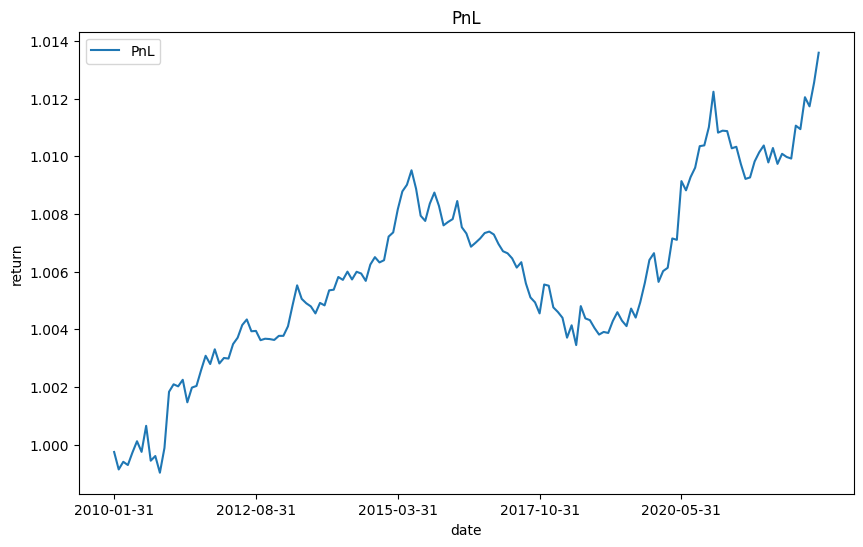

None

In [121]:
test.run()

## Simple strategy demonstration

/tmp/ipykernel_3566888/1985344874.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


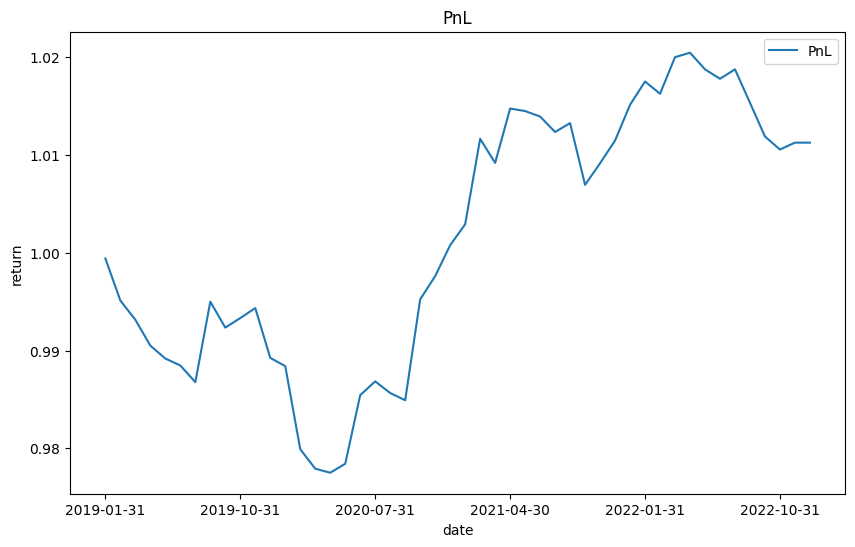

,ret,std
0,1.011257,0.003663


,ret,std
0,1.011257,0.003663


In [53]:
universe = list((set(filters['more_than_5_reviews']) - set(filters['extreme_stocks'])).intersection(set(filters['trade_between_2020_2023'])))
simple_strategy = BackTest(features_db, start_date='2019-01-01', end_date='2022-12-31', universe=universe)
alpha = -simple_strategy.rank('ratingOverall_mean')
simple_strategy.create_alpha(alpha)
simple_strategy.run()

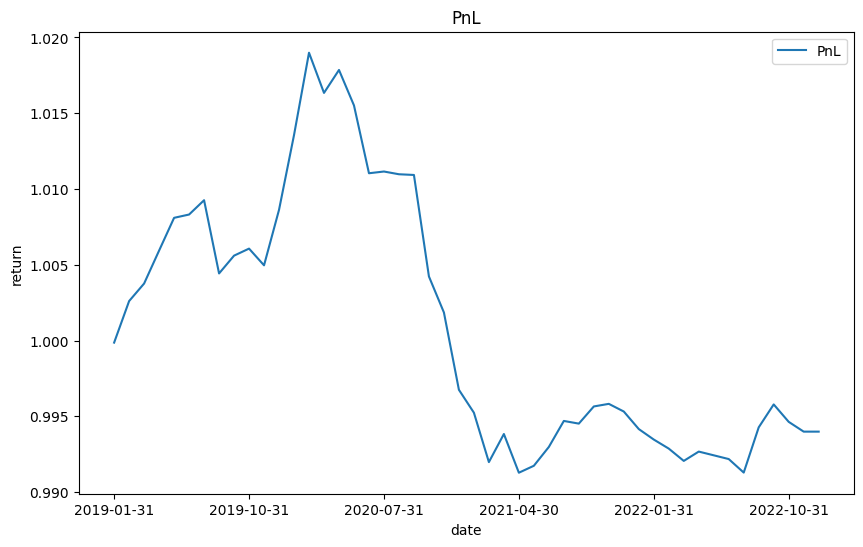

None

In [22]:
alpha = simple_strategy.add('ratingOverall_mean','ratingSeniorLeadership_mean')
simple_strategy.create_alpha(alpha)

simple_strategy.run()

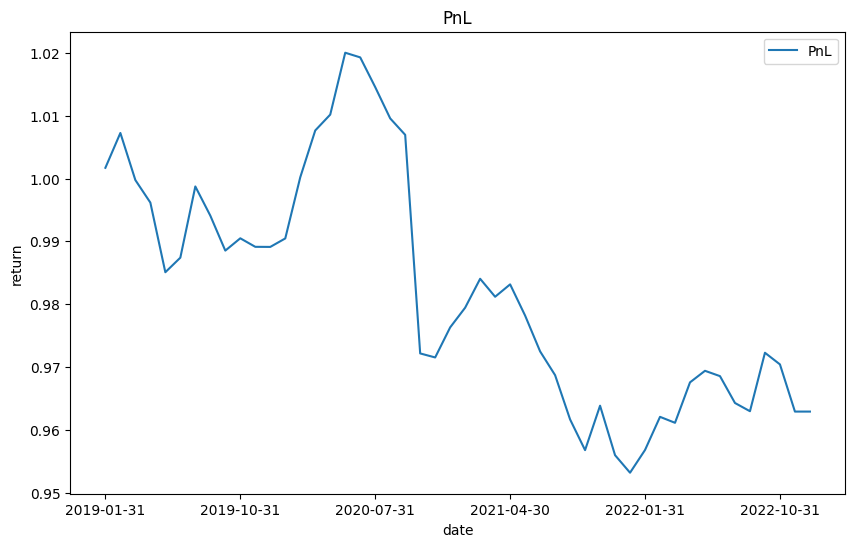

None

In [23]:
alpha = simple_strategy.diff('ratingOverall_mean',12)
simple_strategy.create_alpha(alpha)

simple_strategy.run()

## Example with grouping

In [24]:
industry_mapping = company[['ticker','industryName']]
industry_mapping = industry_mapping[industry_mapping['industryName']!='-']
industry_mapping.rename(columns={'industryName': 'group'}, inplace=True)

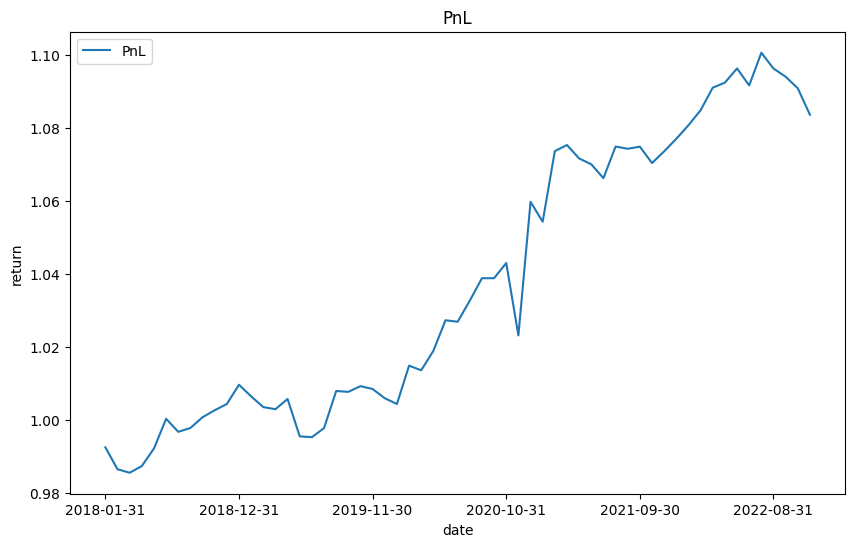

None

In [25]:
group_strategy = BackTest(features_db,grouping=industry_mapping, start_date='2018-01-01')
alpha = -group_strategy.rank('ratingOverall_mean')
group_strategy.create_alpha(alpha)
group_strategy.run()

In [ ]:
# with some filtering

industry_mapping = company[['ticker','industryName']]
industry_mapping = industry_mapping[industry_mapping['industryName']!='-']
industry_mapping.rename(columns={'industryName': 'group'}, inplace=True)

In [127]:
industry_mapping_top10 = industry_mapping[industry_mapping['group'].isin(industry_mapping.groupby('group').count().sort_values(by='ticker',ascending=False)[:10].index)]

In [130]:
group_strategy.diff('ratingOverall_mean', 6)

ticker,Banking & Lending,Biotech & Pharmaceuticals,Computer Hardware Development,Consumer Product Manufacturing,Electronics Manufacturing,Energy & Utilities,Enterprise Software & Network Solutions,Health Care Products Manufacturing,Healthcare Services & Hospitals,Machinery Manufacturing
2008-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-30,-0.103914,-0.009597,0.046325,-0.015654,-0.000859,-0.124085,0.055909,0.265066,-0.231245,0.068418
2023-12-31,0.011640,0.122776,-0.218149,-0.019718,-0.159082,-0.211063,-0.065288,-0.011200,-0.000130,0.187766
2024-01-31,-0.260315,-0.008397,-0.070137,-0.018081,-0.160651,-0.108949,-0.064749,-0.241215,0.166491,0.111868
2024-02-29,0.004276,0.083007,-0.083063,0.277870,-0.057423,-0.066711,-0.024861,0.090085,0.056189,0.174102


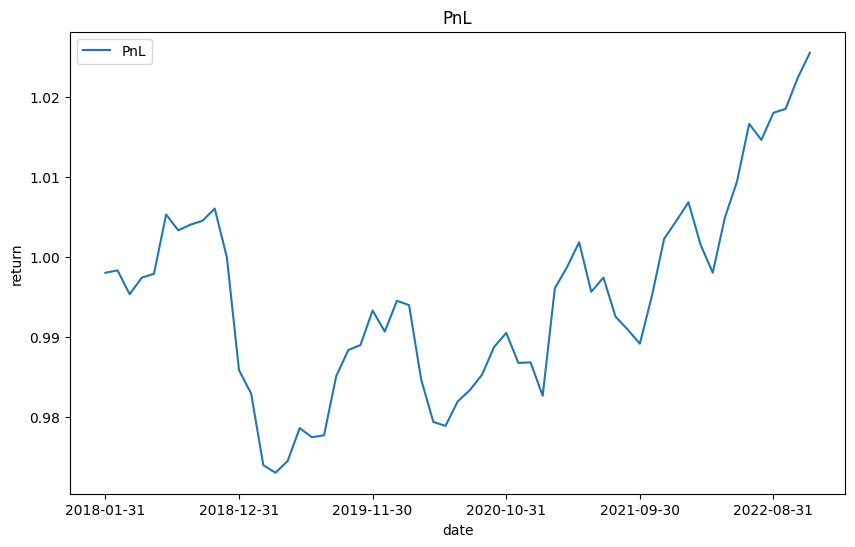

None

In [137]:
group_strategy = BackTest(features_db,grouping=industry_mapping_top10, start_date='2018-01-01')
alpha = -group_strategy.rank(group_strategy.SMA('ratingOverall_mean', 6))
group_strategy.create_alpha(alpha)
group_strategy.run()

# Alpha mining

### rank by industry

In [7]:
filters.keys()

dict_keys(['trade_between_2020_2023', 'more_than_5_reviews', 'more_than_50_reviews', 'on_glassdoor_before_2013', 'more_than_5_companies_per_industry', 'more_than_1_review_per_month', 'more_than_10_review_per_month', 'more_than_1_review_per_quarter', 'more_than_10_review_per_quarter', 'more_than_109_review_per_quarter'])

In [13]:
biotech = by_industry[by_industry['group']=='Biotech & Pharmaceuticals']['ticker'].values
biotech_filter = list(set(biotech) & set(filters['more_than_5_reviews']) & set(filters['trade_between_2020_2023']))

In [57]:
industry_alpha = BackTest(features_db, universe=biotech)

In [ ]:
alpha = -industry_alpha.rank('ratingOverall_mean')
industry_alpha.create_alpha(alpha)
industry_alpha.run(display=False)

/tmp/ipykernel_3406501/4008310557.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


,ret,std
0,0.9222,0.015247


In [60]:
valid_industries = by_industry[by_industry['ticker'].isin(filters['more_than_5_companies_per_industry'])]

In [69]:
industry_rank_alpha = pd.DataFrame()

for feature in [f for f in features_db.columns.get_level_values(0).unique() if f.endswith('_mean')]:
    for industry in valid_industries['group'].unique():
        try:
            universe = by_industry[by_industry['group']==industry]['ticker'].values
            industry_alpha = BackTest(features_db, universe=universe)
            alpha = -industry_alpha.rank(feature)
            industry_alpha.create_alpha(alpha)
            metric = industry_alpha.run(display=False)
            metric['industry'] = [industry]
            metric['feature'] = feature
            industry_rank_alpha = pd.concat([industry_rank_alpha, metric],axis=0)
        except:
            continue

/tmp/ipykernel_3406501/4008310557.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3406501/4008310557.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3406501/4008310557.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1

In [78]:
rank_metrics = industry_rank_alpha.reset_index(drop=True).groupby(['industry', 'feature']).max().unstack(0)
rank_metrics.to_csv('-rank.csv')

In [16]:
rank_metrics=pd.read_pickle('/home/group3/group3/Drafts/Jadon/BT_res/-rank.pkl')

In [42]:
top10industry = by_industry.groupby('group').count().sort_values(by='ticker',ascending=False)[:10].index.values

In [48]:
rank_metrics['ret'].loc[:, top10industry].T.sort_values(by='ratingOverall_mean',ascending=False).T.to_csv('-rank_top10I.csv')

### rank by employee

In [49]:
by_employee

,group,ticker
0,1001 to 5000 Employees,AAC
1,1001 to 5000 Employees,AAON
2,1001 to 5000 Employees,AIR
3,5001 to 10000 Employees,ACCO
4,201 to 500 Employees,ACNB
...,...,...
4462,1001 to 5000 Employees,RDC
4463,10000+ Employees,STE
4464,10000+ Employees,PRGO
4465,1001 to 5000 Employees,SSYS


In [65]:
employee_rank_alpha = pd.DataFrame()

for feature in [f for f in features_db.columns.get_level_values(0).unique() if f.endswith('_mean')]:
    for size in by_employee['group'].unique():
        try:
            universe = list(set(by_employee[by_employee['group']==size]['ticker'].values) & set(filters['more_than_5_reviews']))
            employee_alpha = BackTest(features_db, universe=universe)
            alpha = -employee_alpha.rank(feature)
            employee_alpha.create_alpha(alpha)
            metric = employee_alpha.run(display=False)
            metric['employee'] = [size]
            metric['feature'] = feature
            employee_rank_alpha = pd.concat([employee_rank_alpha, metric],axis=0)
        except:
            continue

/tmp/ipykernel_3433774/4008310557.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3433774/4008310557.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3433774/4008310557.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1

In [56]:
rank_metrics = employee_rank_alpha.reset_index(drop=True).groupby(['employee', 'feature']).max().unstack(0)
rank_metrics.to_pickle('-rank_employee.pkl')

In [66]:
rank_metrics.to_csv('-rank_employee.csv')

### rank by revenue

In [ ]:
revenue_rank_alpha = pd.DataFrame()

for feature in [f for f in features_db.columns.get_level_values(0).unique() if f.endswith('_mean')]:
    for revenue in by_revenue['group'].unique():
        try:
            universe = list(set(by_revenue[by_revenue['group']==revenue]['ticker'].values) & set(filters['more_than_5_reviews']))
            revenue_alpha = BackTest(features_db, universe=universe)
            alpha = -revenue_alpha.rank(feature)
            revenue_alpha.create_alpha(alpha)
            metric = revenue_alpha.run(display=False)
            metric['revenue'] = [revenue]
            metric['feature'] = feature
            revenue_rank_alpha = pd.concat([revenue_rank_alpha, metric],axis=0)
        except:
            continue

In [59]:
rank_metrics = revenue_rank_alpha.reset_index(drop=True).groupby(['revenue', 'feature']).max().unstack(0)
rank_metrics.to_pickle('-rank_revenue.pkl')

In [ ]:
rank_metrics.to_csv('-rank_revenue.pkl')

In [ ]:

employee_alpha = BackTest(features_db, grouping=)
alpha = -employee_alpha.rank(feature)
employee_alpha.create_alpha(alpha)
metric = employee_alpha.run(display=False)
metric['employee'] = [size]
metric['feature'] = feature
employee_rank_alpha = pd.concat([employee_rank_alpha, metric],axis=0)
        

### Combination of ratings

In [54]:
filters.keys()

dict_keys(['trade_between_2020_2023', 'more_than_5_reviews', 'more_than_50_reviews', 'on_glassdoor_before_2013', 'more_than_5_companies_per_industry', 'more_than_1_review_per_month', 'more_than_10_review_per_month', 'more_than_1_review_per_quarter', 'more_than_10_review_per_quarter', 'more_than_109_review_per_quarter', 'extreme_stocks'])

/tmp/ipykernel_3566888/1985344874.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


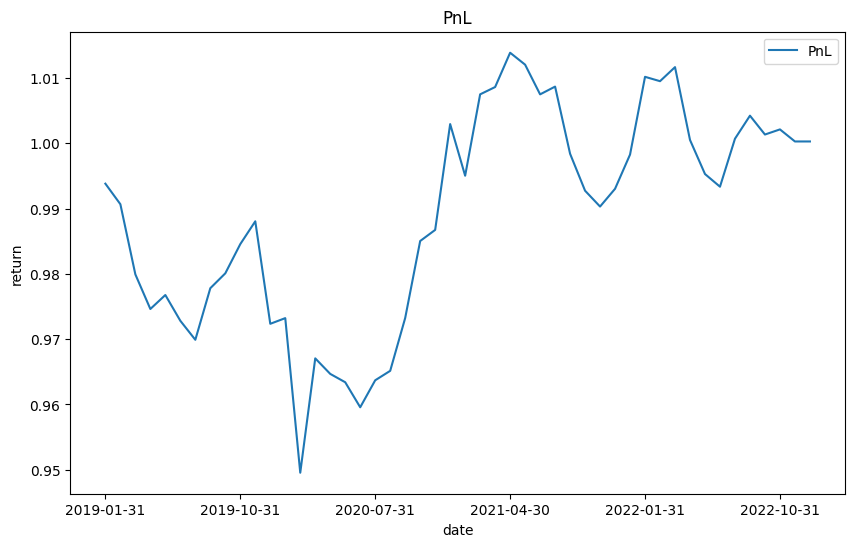

,ret,std
0,1.000263,0.007825


,ret,std
0,1.000263,0.007825


In [60]:
universe = list((set(filters['more_than_109_review_per_quarter']) - set(filters['extreme_stocks'])).intersection(set(filters['trade_between_2020_2023'])))
simple_strategy = BackTest(features_db, start_date='2019-01-01', end_date='2022-12-31', universe=universe)
alpha = simple_strategy.rank(simple_strategy.SMA('ratingOverall_mean',window=12))
simple_strategy.create_alpha(alpha)
simple_strategy.run()

/tmp/ipykernel_3750602/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


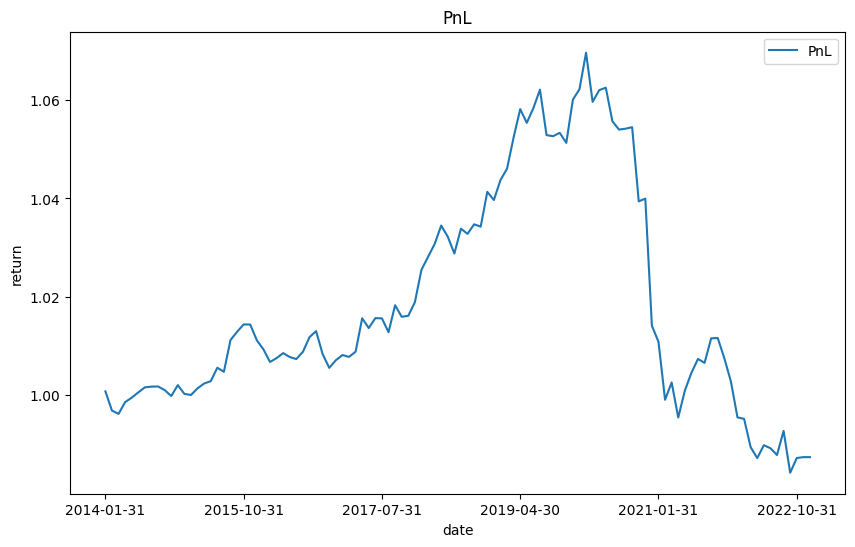

,ret,std,sharpe
0,0.987442,0.004565,-1.345715


,ret,std,sharpe
0,0.987442,0.004565,-1.345715


In [30]:
rolling_ratings = pd.read_csv('/home/group3/group3/Finalized/data/rolling_period_ratings_stats.csv')
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
filtered_df = filtered_df.drop_duplicates()

universe = list(set(universe) & set(features_db['ratingSeniorLeadership_mean'].columns.values))

simple_strategy = BackTest(features_db, start_date='2014-01-01', end_date='2023-12-31', universe=universe)
alpha = simple_strategy.rank(simple_strategy.SMA('ratingSeniorLeadership_mean',window=6))
simple_strategy.create_alpha(alpha)
simple_strategy.run()

# Leadership rating BT

In [9]:
rolling_ratings = pd.read_csv('/home/group3/group3/Finalized/data/rolling_period_ratings_stats.csv')
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
filtered_df = filtered_df.drop_duplicates()

In [10]:
rolling_ratings = pd.read_csv('/home/group3/group3/Finalized/data/rolling_period_ratings_stats.csv')
rolling_ratings['reviewDateTime'] = pd.to_datetime(rolling_ratings['reviewDateTime'])
filters = pd.read_pickle('/home/group3/group3/Finalized/groupings/filters.pkl')
by_employee = pd.read_csv('/home/group3/group3/Finalized/groupings/by_employee.csv')
by_industry = pd.read_csv('/home/group3/group3/Finalized/groupings/by_industry.csv')
by_revenue = pd.read_csv('/home/group3/group3/Finalized/groupings/by_revenue.csv')
rolling_ratings = pd.merge(rolling_ratings, by_industry, on='ticker')

### Long-only strategy

In [ ]:
start_date='2014-01-31'
end_date='2024-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 24].strftime('%Y-%m-%d')] for i in range(len(date_range) - 24)]

rets = {}
sharpe = {}

for start_date, end_date in pairs:
    filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
    universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
    filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
    filtered_df = filtered_df.drop_duplicates()

    rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker','12_ratingSeniorLeadership_mean']]
    long_stocks = rating_tickers[rating_tickers['12_ratingSeniorLeadership_mean']>4].ticker.drop_duplicates()
    short_stocks = rating_tickers[rating_tickers['12_ratingSeniorLeadership_mean']<2].ticker.drop_duplicates()
    universe = list(long_stocks.values) 

    leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
    tmp = leadership_BT.ret.copy()
    tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
    leadership_BT.weights = tmp

    sharpe[start_date] = leadership_BT.run(display_plot=False)['sharpe'][0]

In [82]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 12].strftime('%Y-%m-%d')] for i in range(len(date_range) - 12)]

res = []

for start_date, end_date in pairs:
    print(start_date)
    filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
    universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
    filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
    filtered_df = filtered_df.drop_duplicates()

    rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker','12_ratingSeniorLeadership_mean']]
    long_stocks = rating_tickers[rating_tickers['12_ratingSeniorLeadership_mean']>4].ticker.drop_duplicates()
    short_stocks = rating_tickers[rating_tickers['12_ratingSeniorLeadership_mean']<2].ticker.drop_duplicates()
    universe = list(long_stocks.values) 

    leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
    tmp = leadership_BT.ret.copy()
    tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
    leadership_BT.weights = tmp

    bt_res = leadership_BT.run(display_plot=False)
    datapoint = {
        'startdate': start_date,
        'enddate': end_date,
        'ret': bt_res['ret'][0],
        'sharpe': bt_res['sharpe'][0],
        'universe': list(long_stocks.values),
    }
    res.append(datapoint)

res = pd.DataFrame(res)


/tmp/ipykernel_3778094/101530475.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')


2014-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-02-28


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-02-28


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-02-29


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-02-28


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-02-28


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-02-28


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-02-29


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-02-28


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-03-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-04-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-05-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-06-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-07-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-08-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-09-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-10-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-11-30


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-12-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2022-01-31


/tmp/ipykernel_3778094/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


In [ ]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 12].strftime('%Y-%m-%d')] for i in range(len(date_range) - 12)]

res = []

for start_date, end_date in pairs:
    print(start_date)
    filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
    universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
    filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
    filtered_df = filtered_df.drop_duplicates()

    rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker','12_ratingSeniorLeadership_mean']]
    long_stocks = rating_tickers[rating_tickers['12_ratingSeniorLeadership_mean']>4].ticker.drop_duplicates()
    short_stocks = rating_tickers[rating_tickers['12_ratingSeniorLeadership_mean']<2].ticker.drop_duplicates()
    universe = list(long_stocks.values) 

    leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
    tmp = leadership_BT.ret.copy()
    tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
    tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
    leadership_BT.weights = tmp

    bt_res = leadership_BT.run(display_plot=False)
    datapoint = {
        'startdate': start_date,
        'enddate': end_date,
        'ret': bt_res['ret'][0],
        'sharpe': bt_res['sharpe'][0],
        'long_universe': list(long_stocks.values),
        'short_universe': list(short_stocks.values)
    }
    res.append(datapoint)

res = pd.DataFrame(res)


In [33]:
res.to_csv('1YLongShort_Leaderhsip.csv',index=False)

In [34]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 12].strftime('%Y-%m-%d')] for i in range(len(date_range) - 12)]

res = []
category = '12_ratingCareerOpportunities_mean'
for start_date, end_date in pairs:
    filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
    universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
    filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
    filtered_df = filtered_df.drop_duplicates()

    rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker',category]]
    long_stocks = rating_tickers[rating_tickers[category]>4].ticker.drop_duplicates()
    short_stocks = rating_tickers[rating_tickers[category]<2].ticker.drop_duplicates()
    universe = list(long_stocks.values) 

    leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
    tmp = leadership_BT.ret.copy()
    tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
    # tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
    leadership_BT.weights = tmp

    bt_res = leadership_BT.run(display_plot=False)
    datapoint = {
        'startdate': start_date,
        'enddate': end_date,
        'ret': bt_res['ret'][0],
        'sharpe': bt_res['sharpe'][0],
        'long_universe': list(long_stocks.values),
        # 'short_universe': list(short_stocks.values)
    }
    res.append(datapoint)

res = pd.DataFrame(res)


/tmp/ipykernel_3779055/2741726834.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')


2014-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-02-28


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2014-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-02-28


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2015-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-02-29


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2016-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-02-28


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2017-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-02-28


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2018-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-02-28


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2019-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-02-29


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2020-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-02-28


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-03-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-04-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-05-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-06-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-07-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-08-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-09-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-10-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-11-30


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2021-12-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


2022-01-31


/tmp/ipykernel_3779055/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]


In [35]:
res.to_csv('1YLong_career.csv',index=False)

In [37]:
filtered_df.filter(like='12_').filter(like='_mean').columns

Index(['12_ratingOverall_mean', '12_ratingCareerOpportunities_mean',
       '12_ratingCompensationAndBenefits_mean',
       '12_ratingCultureAndValues_mean', '12_ratingSeniorLeadership_mean',
       '12_ratingWorkLifeBalance_mean', '12_ratingDiversityAndInclusion_mean'],
      dtype='object')

In [9]:
categories = [
       '12_ratingOverall_mean', '12_ratingCareerOpportunities_mean',
       '12_ratingCompensationAndBenefits_mean',
       '12_ratingCultureAndValues_mean', '12_ratingSeniorLeadership_mean',
       '12_ratingWorkLifeBalance_mean']

In [27]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 12].strftime('%Y-%m-%d')] for i in range(len(date_range) - 12)]

for category in categories:
    res = []
    for start_date, end_date in pairs:
        filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
        universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
        filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
        filtered_df = filtered_df.drop_duplicates()

        rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker',category]]
        long_stocks = rating_tickers[rating_tickers[category]>4].ticker.drop_duplicates()
        short_stocks = rating_tickers[rating_tickers[category]<2].ticker.drop_duplicates()
        universe = list(long_stocks.values) + list(short_stocks.values)

        leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
        tmp = leadership_BT.ret.copy()
        tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
        tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
        leadership_BT.weights = tmp

        bt_res = leadership_BT.run(display_plot=False)
        datapoint = {
            'startdate': start_date,
            'enddate': end_date,
            'ret': bt_res['ret'][0],
            'sharpe': bt_res['sharpe'][0],
            'long_universe': list(long_stocks.values),
            'short_universe': list(short_stocks.values)
        }
        res.append(datapoint)

    res = pd.DataFrame(res)
    res.to_csv(f'1YLongShort_{category}.csv', index=False)

/tmp/ipykernel_3805431/1938410893.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fu

In [ ]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 24].strftime('%Y-%m-%d')] for i in range(len(date_range) - 24)]

for category in categories:
    res = []
    for start_date, end_date in pairs:
        filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
        universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
        filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
        filtered_df = filtered_df.drop_duplicates()

        rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker',category]]
        long_stocks = rating_tickers[rating_tickers[category]>4].ticker.drop_duplicates()
        universe = list(long_stocks.values) 

        leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
        tmp = leadership_BT.ret.copy()
        tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
        # tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
        leadership_BT.weights = tmp

        bt_res = leadership_BT.run(display_plot=False)
        datapoint = {
            'startdate': start_date,
            'enddate': end_date,
            'ret': bt_res['ret'][0],
            'sharpe': bt_res['sharpe'][0],
            'long_universe': list(long_stocks.values),
        }
        res.append(datapoint)

    res = pd.DataFrame(res)
    res.to_csv(f'2YLong_{category}.csv', index=False)

In [20]:
# value-weighted portfolio

start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 24].strftime('%Y-%m-%d')] for i in range(len(date_range) - 24)]
categories = ['12_ratingSeniorLeadership_mean']
for category in categories:
    res = []
    for start_date, end_date in pairs:
        filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
        universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
        filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
        filtered_df = filtered_df.drop_duplicates()

        rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker',category]]
        long_stocks = rating_tickers[rating_tickers[category]>4].ticker.drop_duplicates()
        universe = list(long_stocks.values) 

        leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
        tmp = leadership_BT.ret.copy()
        # print((rating_tickers[rating_tickers[category]>4][category].sum()))
        tmp.loc[:, list(long_stocks.values)] = rating_tickers[rating_tickers[category]>4][category]/(rating_tickers[rating_tickers[category]>4][category].sum())
        # tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
        leadership_BT.weights = tmp

        bt_res = leadership_BT.run(display_plot=False)
        datapoint = {
            'startdate': start_date,
            'enddate': end_date,
            'ret': bt_res['ret'][0],
            'sharpe': bt_res['sharpe'][0],
            'long_universe': list(long_stocks.values),
        }
        res.append(datapoint)

    res = pd.DataFrame(res)
    res.to_csv(f'2YLong_{category}.csv', index=False)

/tmp/ipykernel_3852656/3947567555.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')


ValueError: setting an array element with a sequence.

### Portfolio analysis

In [23]:
ret = pd.read_csv("/home/group3/group3/Drafts/Jadon/BT_res/1YLong_Leadership.csv")
ret.set_index('startdate',inplace=True)
ret['universe'] = ret['universe'].apply(lambda x: ast.literal_eval(x))

In [31]:
diff = []
for i in range(1,len(ret)):
    list1 = ret.iloc[i]['universe']
    list2 = ret.iloc[i-1]['universe']

    union = list(set(list1) | set(list2))
    intersection = list(set(list1) & set(list2))

    diff.append(
        {
            'date': ret.iloc[i-1].name,
            'diff': len(union) - len(intersection),
        }
    )

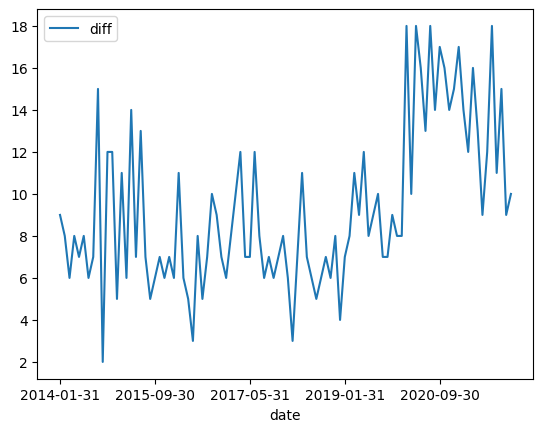

In [39]:
diff_df = pd.DataFrame(diff)
diff_df.set_index('date',inplace=True)
diff_df.plot()
# plt.xticks(range(0, len(diff_df), int(len(diff_df)/5)))
plt.show()

In [10]:
ret['industries'] = ret['universe'].apply(lambda x: [by_industry[by_industry['ticker']==i]['group'].values[0] if len(by_industry[by_industry['ticker']==i])>0 else None for i in x])

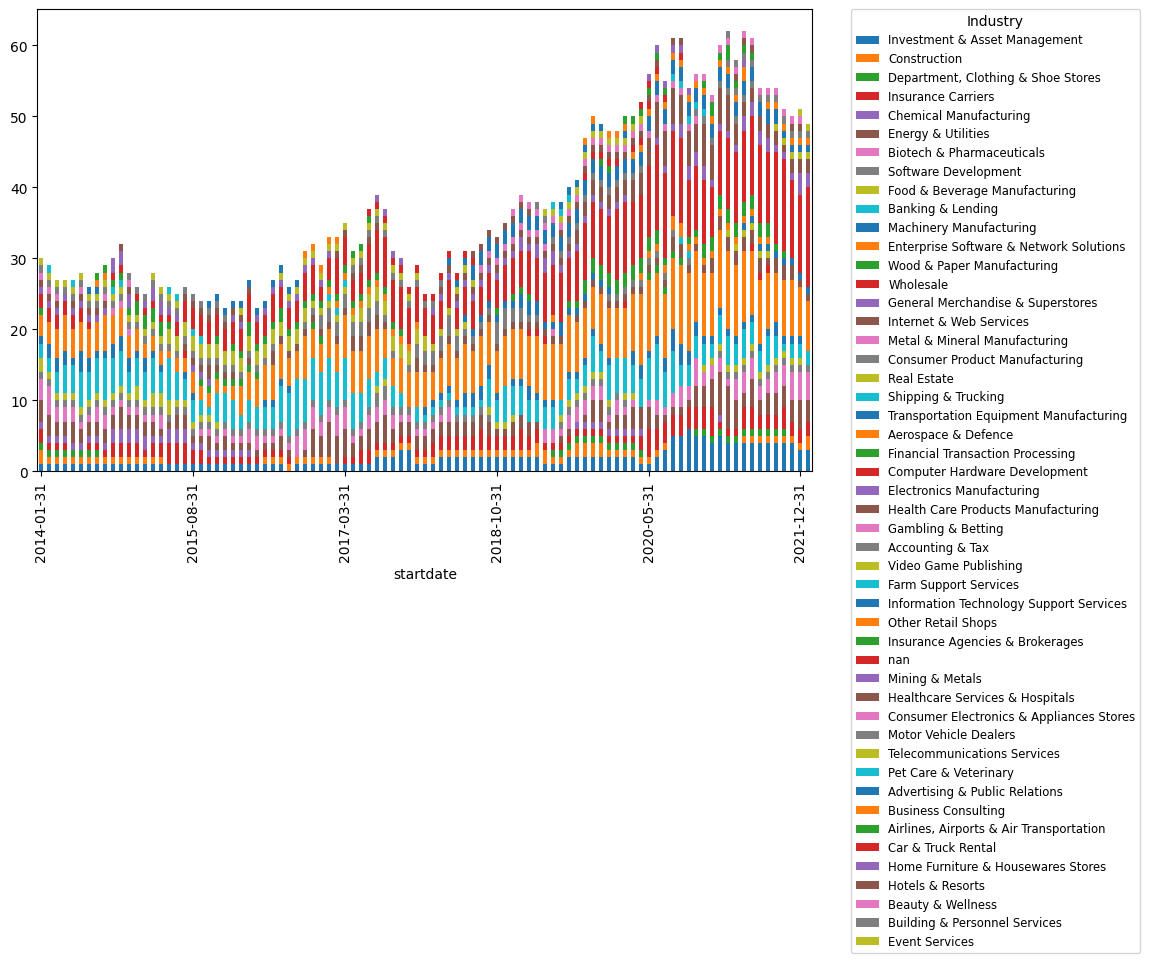

In [102]:
counters = []
for lst in ret['industries']:
    counters.append(Counter(lst))

count_df = pd.DataFrame(counters).fillna(0)  # Fill missing values with 0
count_df.set_index(ret.index,inplace=True)
count_df = count_df.astype(int)
count_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.xticks(range(0, len(ret), int(len(ret)/5)))
plt.show()

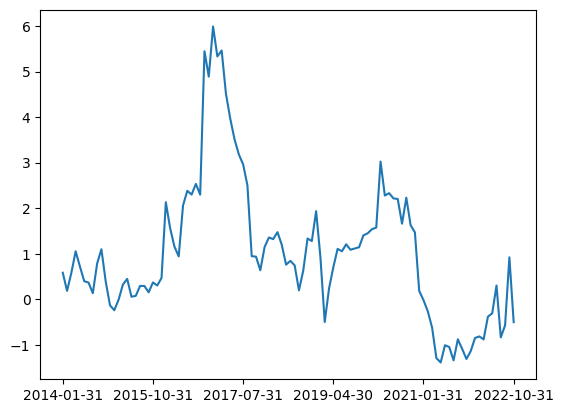

In [26]:
plt.plot(ret['sharpe'].dropna())
plt.xticks(range(0, len(ret), int(len(ret)/5)))
plt.show()

In [29]:
ret['Universe'].apply(lambda x: len(x)).mean()

np.float64(249.61682242990653)

In [31]:
ret['ret'].mean()

np.float64(1.211968998062897)

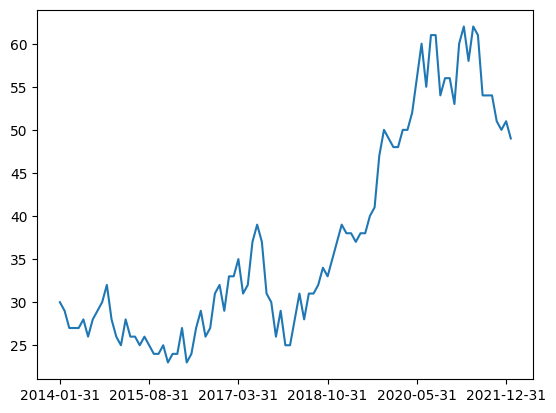

In [32]:
plt.plot(ret['universe'].apply(lambda x: len(x)))
plt.xticks(range(0, len(ret), int(len(ret)/5)))
plt.show()

([<matplotlib.axis.XTick at 0x7f884a07c850>,
 [Text(0, 0, '2014-01-31'),
  Text(21, 0, '2015-10-31'),
  Text(42, 0, '2017-07-31'),
  Text(63, 0, '2019-04-30'),
  Text(84, 0, '2021-01-31'),
  Text(105, 0, '2022-10-31')])

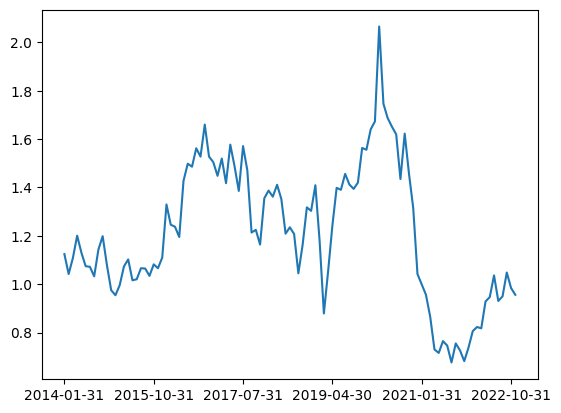

In [33]:
plt.plot(ret['ret'])
plt.xticks(range(0, len(ret), int(len(ret)/5)))

In [37]:
(ret['ret'].mean()-1.02)*12/(ret['ret'].std()*np.sqrt(12))

np.float64(2.3519691024517324)

In [13]:
ret['universe'].apply(lambda x: len(x)).mean()

np.float64(37.22680412371134)

### Short Portfolio - Large company that do poorly

In [14]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 24].strftime('%Y-%m-%d')] for i in range(len(date_range) - 24)]

# categories = [
#        '12_ratingOverall_mean', '12_ratingCareerOpportunities_mean',
#        '12_ratingCompensationAndBenefits_mean',
#        '12_ratingCultureAndValues_mean', '12_ratingSeniorLeadership_mean',
#        '12_ratingWorkLifeBalance_mean']

categories = [
       '12_ratingSeniorLeadership_mean',
      ]

for category in categories:
    res = []
    for start_date, end_date in pairs:
        filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
        universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
        filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
        # also filter in large companies only
        large_employee_companies = by_employee[by_employee['group'].isin(['5001 to 10000 Employees','10000+ Employees'])]['ticker'].values
        # filtered_df = filtered_df[filtered_df['ticker'].isin(large_employee_companies)]
        filtered_df = filtered_df.drop_duplicates()

        rating_tickers = filtered_df[filtered_df['reviewDateTime']==start_date][['ticker',category]]
        # long_stocks = rating_tickers[rating_tickers[category]>4].ticker.drop_duplicates()
        short_stocks = rating_tickers[rating_tickers[category]<2].ticker.drop_duplicates()
        universe = list(short_stocks.values) 

        leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
        tmp = leadership_BT.ret.copy()
        # tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
        tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
        leadership_BT.weights = tmp

        bt_res = leadership_BT.run(display_plot=False)
        datapoint = {
            'startdate': start_date,
            'enddate': end_date,
            'ret': bt_res['ret'][0],
            'sharpe': bt_res['sharpe'][0],
            # 'long_universe': list(long_stocks.values),
            'short_universe': list(short_stocks.values)
        }
        res.append(datapoint)

    res = pd.DataFrame(res)
    res.to_csv(f'2YShort_{category}.csv', index=False)

/tmp/ipykernel_3805431/3594268190.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fu

### Portfolio on CEO Approval

In [11]:
ceo_approved_df = pd.read_csv('/home/group3/group3/Finalized/data/OLS_dfs/ceo_approval.csv')
ceo_disapproved_df = pd.read_csv('/home/group3/group3/Finalized/data/OLS_dfs/ceo_disapproval.csv')
merge_ceo_df = pd.merge(ceo_approved_df, ceo_disapproved_df, on=['ticker','reviewDateTime'])
merge_ceo_df['diff'] = merge_ceo_df['12_ratingOverall_count_x'] - merge_ceo_df['12_ratingOverall_count_y']
merge_ceo_df['diff_ratio'] = merge_ceo_df['diff']/(merge_ceo_df['12_ratingOverall_count_x'] + merge_ceo_df['12_ratingOverall_count_y'])

<Axes: >

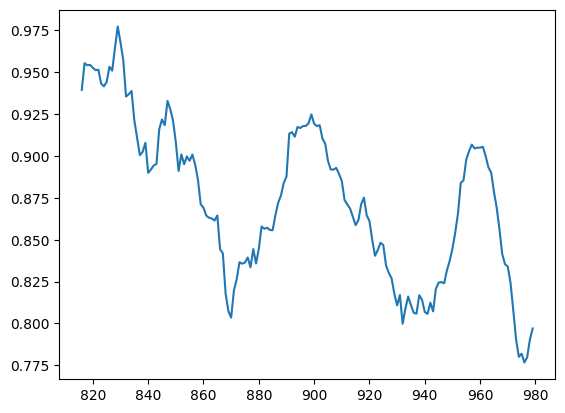

In [15]:
merge_ceo_df[merge_ceo_df['ticker']=='AAPL']['diff_ratio'].plot()

<Axes: xlabel='diff_ratio', ylabel='Count'>

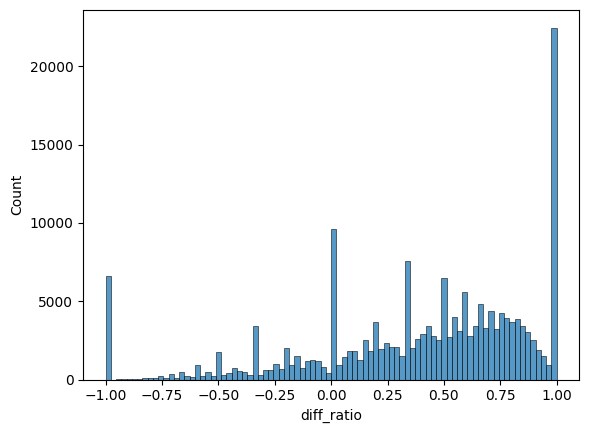

In [16]:
sns.histplot(merge_ceo_df['diff_ratio'])

In [17]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 24].strftime('%Y-%m-%d')] for i in range(len(date_range) - 24)]

res = []

for start_date, end_date in pairs:
    filtered_df = merge_ceo_df[(merge_ceo_df['reviewDateTime']>'2014-01-01')] 
    universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
    filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
    filtered_df = filtered_df.drop_duplicates()

    # approved = filtered_df[filtered_df['diff']>100]
    approved = filtered_df[filtered_df['diff_ratio']>0.75]
    notapproved = filtered_df[filtered_df['diff_ratio']<0]

    long_stocks = filtered_df[filtered_df['diff']>100].ticker.drop_duplicates()
    # short_stocks = filtered_df[filtered_df['diff']<0].ticker.drop_duplicates()
    universe = list(long_stocks.values) 

    leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
    tmp = leadership_BT.ret.copy()
    tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
    # tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
    leadership_BT.weights = tmp

    bt_res = leadership_BT.run(display_plot=False)
    datapoint = {
        'startdate': start_date,
        'enddate': end_date,
        'ret': bt_res['ret'][0],
        'sharpe': bt_res['sharpe'][0],
        'long_universe': list(long_stocks.values),
        # 'short_universe': list(short_stocks.values)
    }
    res.append(datapoint)

res = pd.DataFrame(res)
res.to_csv(f'2YLong_{"CEO_Ratio_0.75TH"}.csv', index=False)

/tmp/ipykernel_3852656/373606716.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')
/tmp/ipykernel_3852656/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3852656/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3852656/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

In [25]:
update_json('experiments.json', '2YLong_CEO_Ratio_0.75TH', res)

In [34]:
start_date='2014-01-31'
end_date='2023-01-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
pairs = [[date_range[i].strftime('%Y-%m-%d'), date_range[i + 24].strftime('%Y-%m-%d')] for i in range(len(date_range) - 24)]

res = []

for start_date, end_date in pairs:
    filtered_df = merge_ceo_df[(merge_ceo_df['reviewDateTime']>'2014-01-01')] 
    universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
    filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
    filtered_df = filtered_df.drop_duplicates()


    approved = filtered_df[filtered_df['diff']>100]
    notapproved = filtered_df[filtered_df['diff']<0]

    long_stocks = filtered_df[filtered_df['diff']>100].ticker.drop_duplicates()
    # short_stocks = filtered_df[filtered_df['diff']<0].ticker.drop_duplicates()
    universe = list(long_stocks.values) 

    leadership_BT = BackTest(features_db, universe=universe, start_date=start_date, end_date=end_date, market_neutral=False)
    tmp = leadership_BT.ret.copy()
    tmp.loc[:, list(long_stocks.values)] = 1/len(list(long_stocks.values))
    # tmp.loc[:, list(short_stocks.values)] = -1/len(list(short_stocks.values))
    leadership_BT.weights = tmp

    bt_res = leadership_BT.run(display_plot=False)
    datapoint = {
        'startdate': start_date,
        'enddate': end_date,
        'ret': bt_res['ret'][0],
        'sharpe': bt_res['sharpe'][0],
        'long_universe': list(long_stocks.values),
        # 'short_universe': list(short_stocks.values)
    }
    res.append(datapoint)

res = pd.DataFrame(res)
res.to_csv(f'2YLong_{"CEO"}.csv', index=False)

/tmp/ipykernel_3805431/2585144166.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='M')
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metrics['ret'] = (1+self.portfolio_returns).cumprod()[-1]
/tmp/ipykernel_3805431/155269188.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fu

<Axes: >

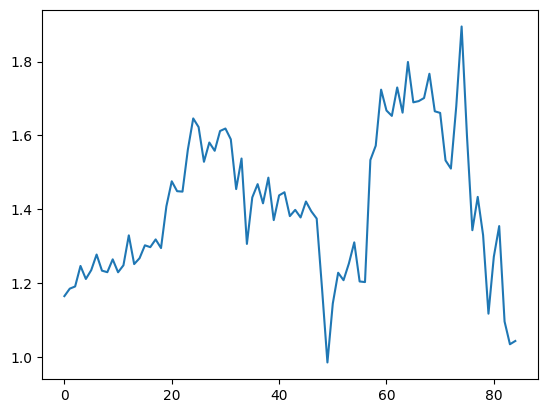

In [38]:
res['ret'].plot()